In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [101]:
df = pd.read_csv('CreditCardUsage.csv')

In [102]:
df.head(3)

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,FULL_PAYMENT
0,41,95,0,95,0,0,2,1000.0,202,140.0,12,0
1,3202,0,0,0,6443,4,0,7000.0,4103,1072.0,12,0
2,2495,773,773,0,0,0,12,7500.0,622,627.0,12,0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BALANCE                 8950 non-null   int64  
 1   PURCHASES               8950 non-null   int64  
 2   ONEOFF_PURCHASES        8950 non-null   int64  
 3   INSTALLMENTS_PURCHASES  8950 non-null   int64  
 4   CASH_ADVANCE            8950 non-null   int64  
 5   CASH_ADVANCE_TRX        8950 non-null   int64  
 6   PURCHASES_TRX           8950 non-null   int64  
 7   CREDIT_LIMIT            8949 non-null   float64
 8   PAYMENTS                8950 non-null   int64  
 9   MINIMUM_PAYMENTS        8637 non-null   float64
 10  TENURE                  8950 non-null   int64  
 11  FULL_PAYMENT            8950 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 839.2 KB


In [104]:
df.dropna(inplace=True)

In [105]:
df.drop_duplicates()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,FULL_PAYMENT
0,41,95,0,95,0,0,2,1000.0,202,140.0,12,0
1,3202,0,0,0,6443,4,0,7000.0,4103,1072.0,12,0
2,2495,773,773,0,0,0,12,7500.0,622,627.0,12,0
4,818,16,16,0,0,0,1,1200.0,678,245.0,12,0
5,1810,1333,0,1333,0,0,8,1800.0,1400,2407.0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8943,6,21,21,0,0,0,1,500.0,59,43.0,6,0
8945,28,291,0,291,0,0,6,1000.0,326,49.0,6,1
8947,23,144,0,144,0,0,5,1000.0,81,82.0,6,0
8948,13,0,0,0,37,2,0,500.0,53,56.0,6,0


In [106]:
df.columns

Index(['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT',
       'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE', 'FULL_PAYMENT'],
      dtype='object')

In [107]:
def format_column_names(df):
    """
    Format all column names in a DataFrame to snake_case.

    Parameters:
        df (pandas.DataFrame): DataFrame whose column names are to be formatted.

    Returns:
        pandas.DataFrame: DataFrame with column names formatted to snake_case.
    """
    formatted_columns = [col.replace(' ', '_').lower() for col in df.columns]
    df.columns = formatted_columns
    return df

In [108]:
df = format_column_names(df)

In [109]:
df.columns

Index(['balance', 'purchases', 'oneoff_purchases', 'installments_purchases',
       'cash_advance', 'cash_advance_trx', 'purchases_trx', 'credit_limit',
       'payments', 'minimum_payments', 'tenure', 'full_payment'],
      dtype='object')

In [110]:
categorical_columns = ['tenure', 'full_payment']
numerical_columns = [col for col in df.columns if col not in categorical_columns]

# EDA

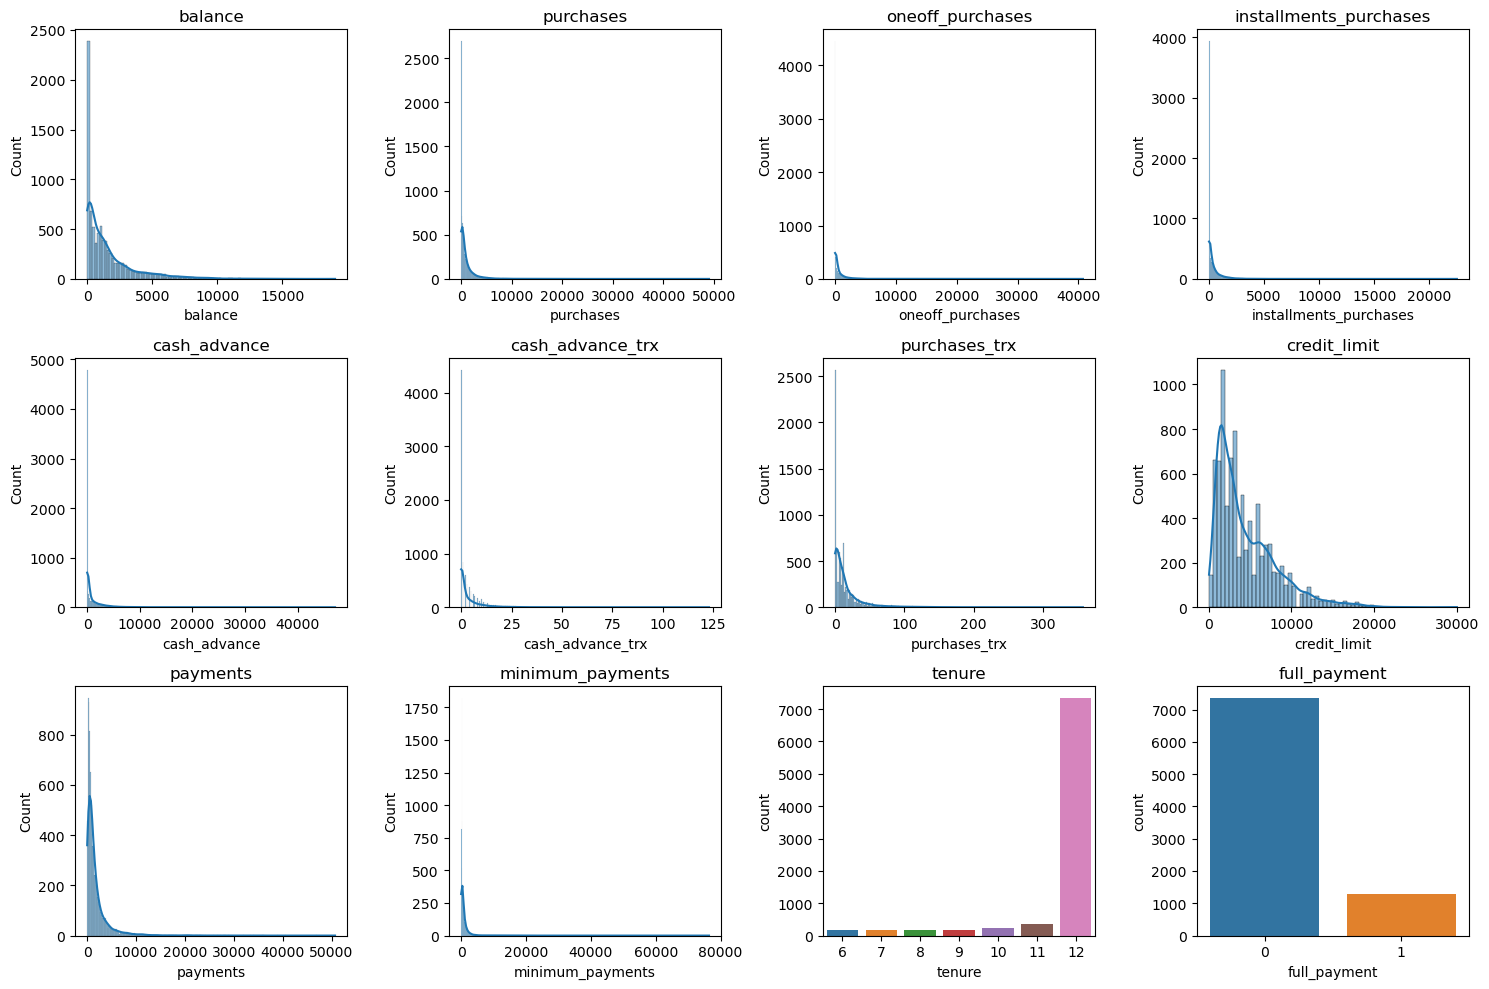

In [111]:
# Plotting subplots
num_rows = 3
num_cols = (len(numerical_columns) + len(categorical_columns) + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], ax=axes[row][col], kde=True)
    axes[row][col].set_title(column)

for i, column in enumerate(categorical_columns):
    row = (i + len(numerical_columns)) // num_cols
    col = (i + len(numerical_columns)) % num_cols
    sns.countplot(data=df, x=column, ax=axes[row][col])
    axes[row][col].set_title(column)

plt.tight_layout()
plt.show()

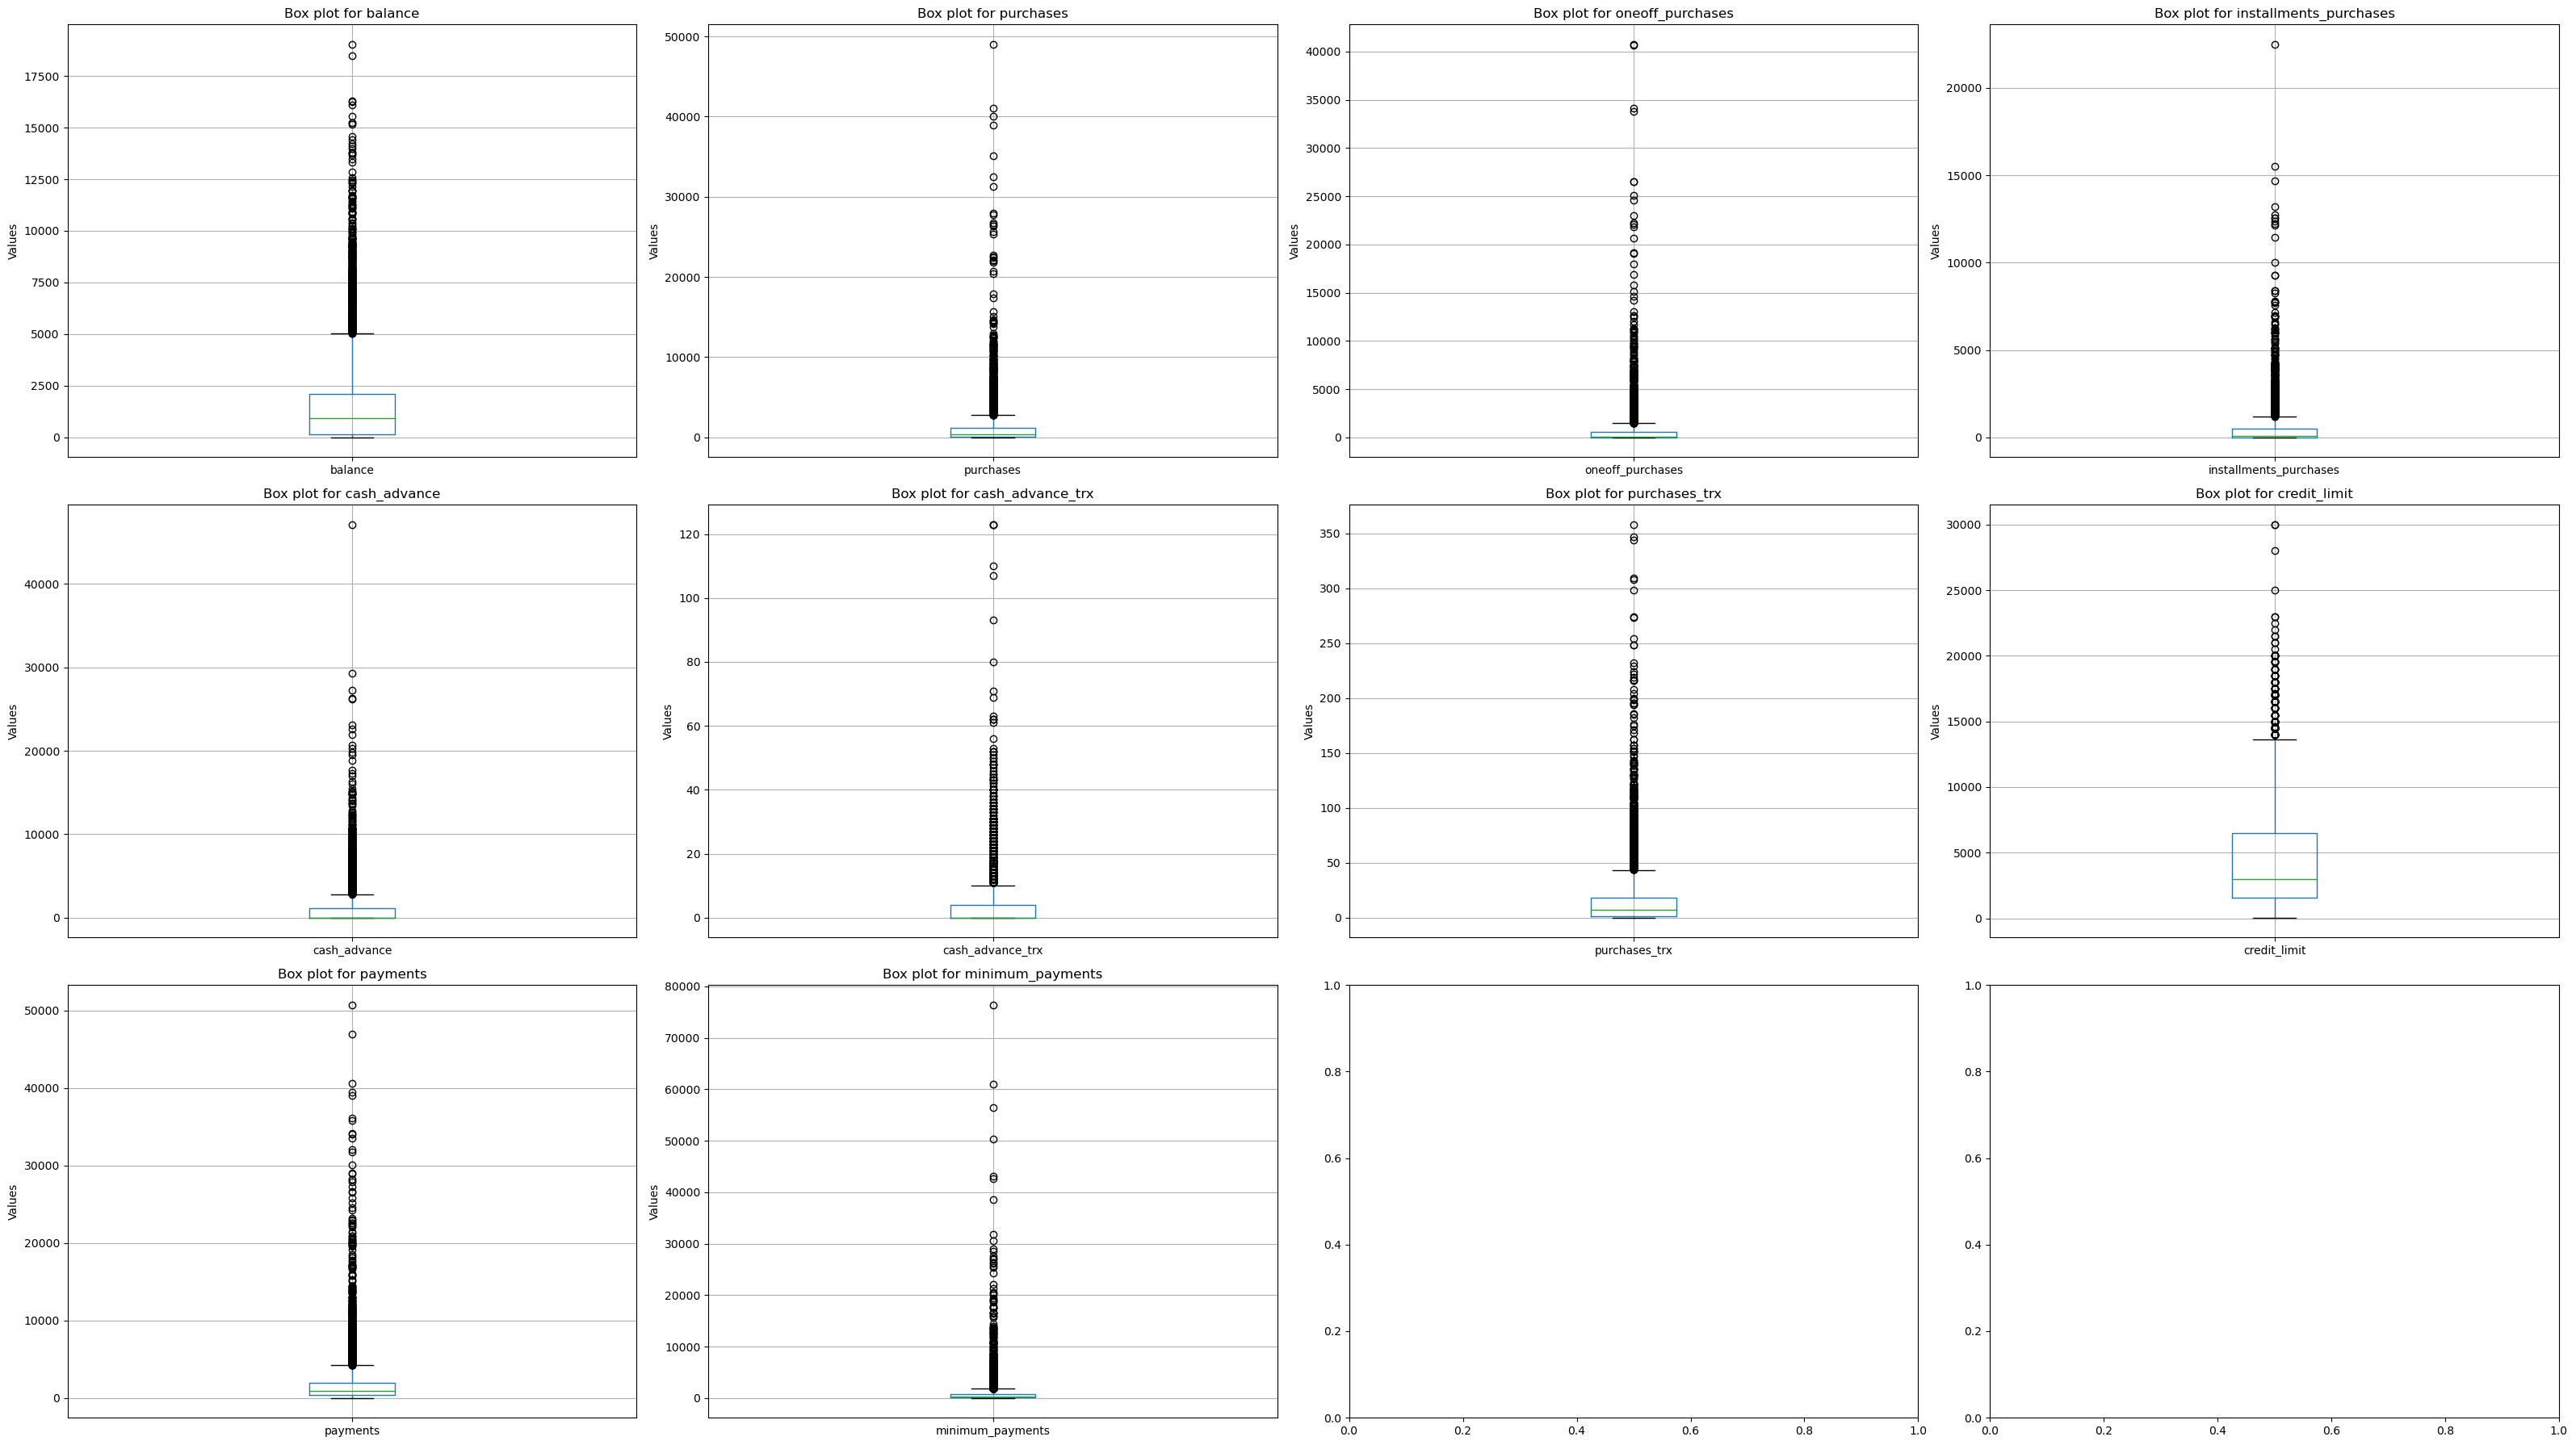

In [112]:
num_rows = 3
num_cols = len(numerical_columns) // num_rows + (len(numerical_columns) % num_rows > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axes = axes.ravel()  # Flatten the axes array

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    df.boxplot(column=col, ax=ax)
    ax.set_title(f'Box plot for {col}')
    ax.set_ylabel('Values')

plt.tight_layout()
plt.show()

In [113]:
def remove_outliers(df, column_names=None):
    """
    Remove outliers from specific columns in the DataFrame based on the interquartile range (IQR) method,
    or remove outliers from all numerical columns if column_names is None.

    Parameters:
    - df: DataFrame
        The DataFrame containing the data.
    - column_names: list or None, default None
        The list of column names for which outliers are to be removed,
        or None to remove outliers from all numerical columns.

    Returns:
    - df_filtered: DataFrame
        The DataFrame with outliers removed.
    """
    if column_names is None:
        numerical_columns = df.select_dtypes(include='number').columns
    else:
        numerical_columns = column_names

    total_removed = 0
    total_rows = len(df)

    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers from the specified column
        removed_rows = len(df) - len(df[(df[col] >= lower_bound) & (df[col] <= upper_bound)])
        total_removed += removed_rows

        # Update DataFrame
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        # Print the number and percentage of removed values if any rows have been removed
        percentage_removed = (removed_rows / total_rows) * 100
        print(f"Removed {removed_rows} rows ({percentage_removed:.2f}%) due to outliers in column '{col}'.")

    # Print total number and percentage of removed rows
    total_percentage_removed = (total_removed / total_rows) * 100
    print(f"Total Removed {total_removed} rows ({total_percentage_removed:.2f}%) due to outliers.")

    return df


In [114]:
# f = remove_outliers(df, column_names=numerical_columns)

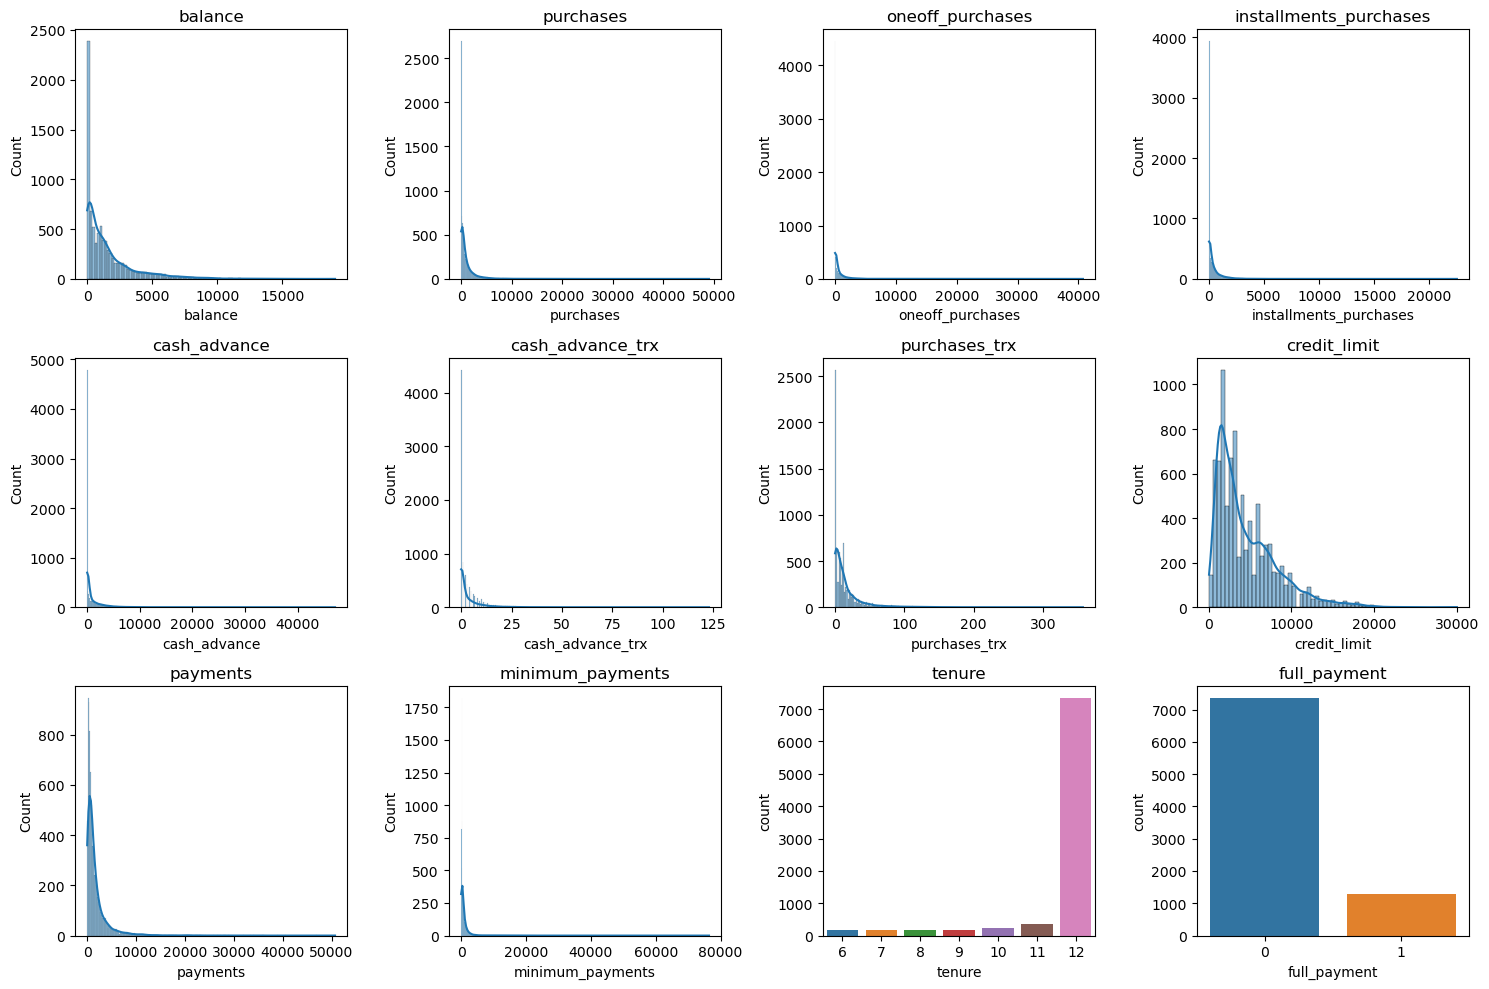

In [115]:
# Plotting subplots
num_rows = 3
num_cols = (len(numerical_columns) + len(categorical_columns) + num_rows - 1) // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], ax=axes[row][col], kde=True)
    axes[row][col].set_title(column)

for i, column in enumerate(categorical_columns):
    row = (i + len(numerical_columns)) // num_cols
    col = (i + len(numerical_columns)) % num_cols
    sns.countplot(data=df, x=column, ax=axes[row][col])
    axes[row][col].set_title(column)

plt.tight_layout()
plt.show()

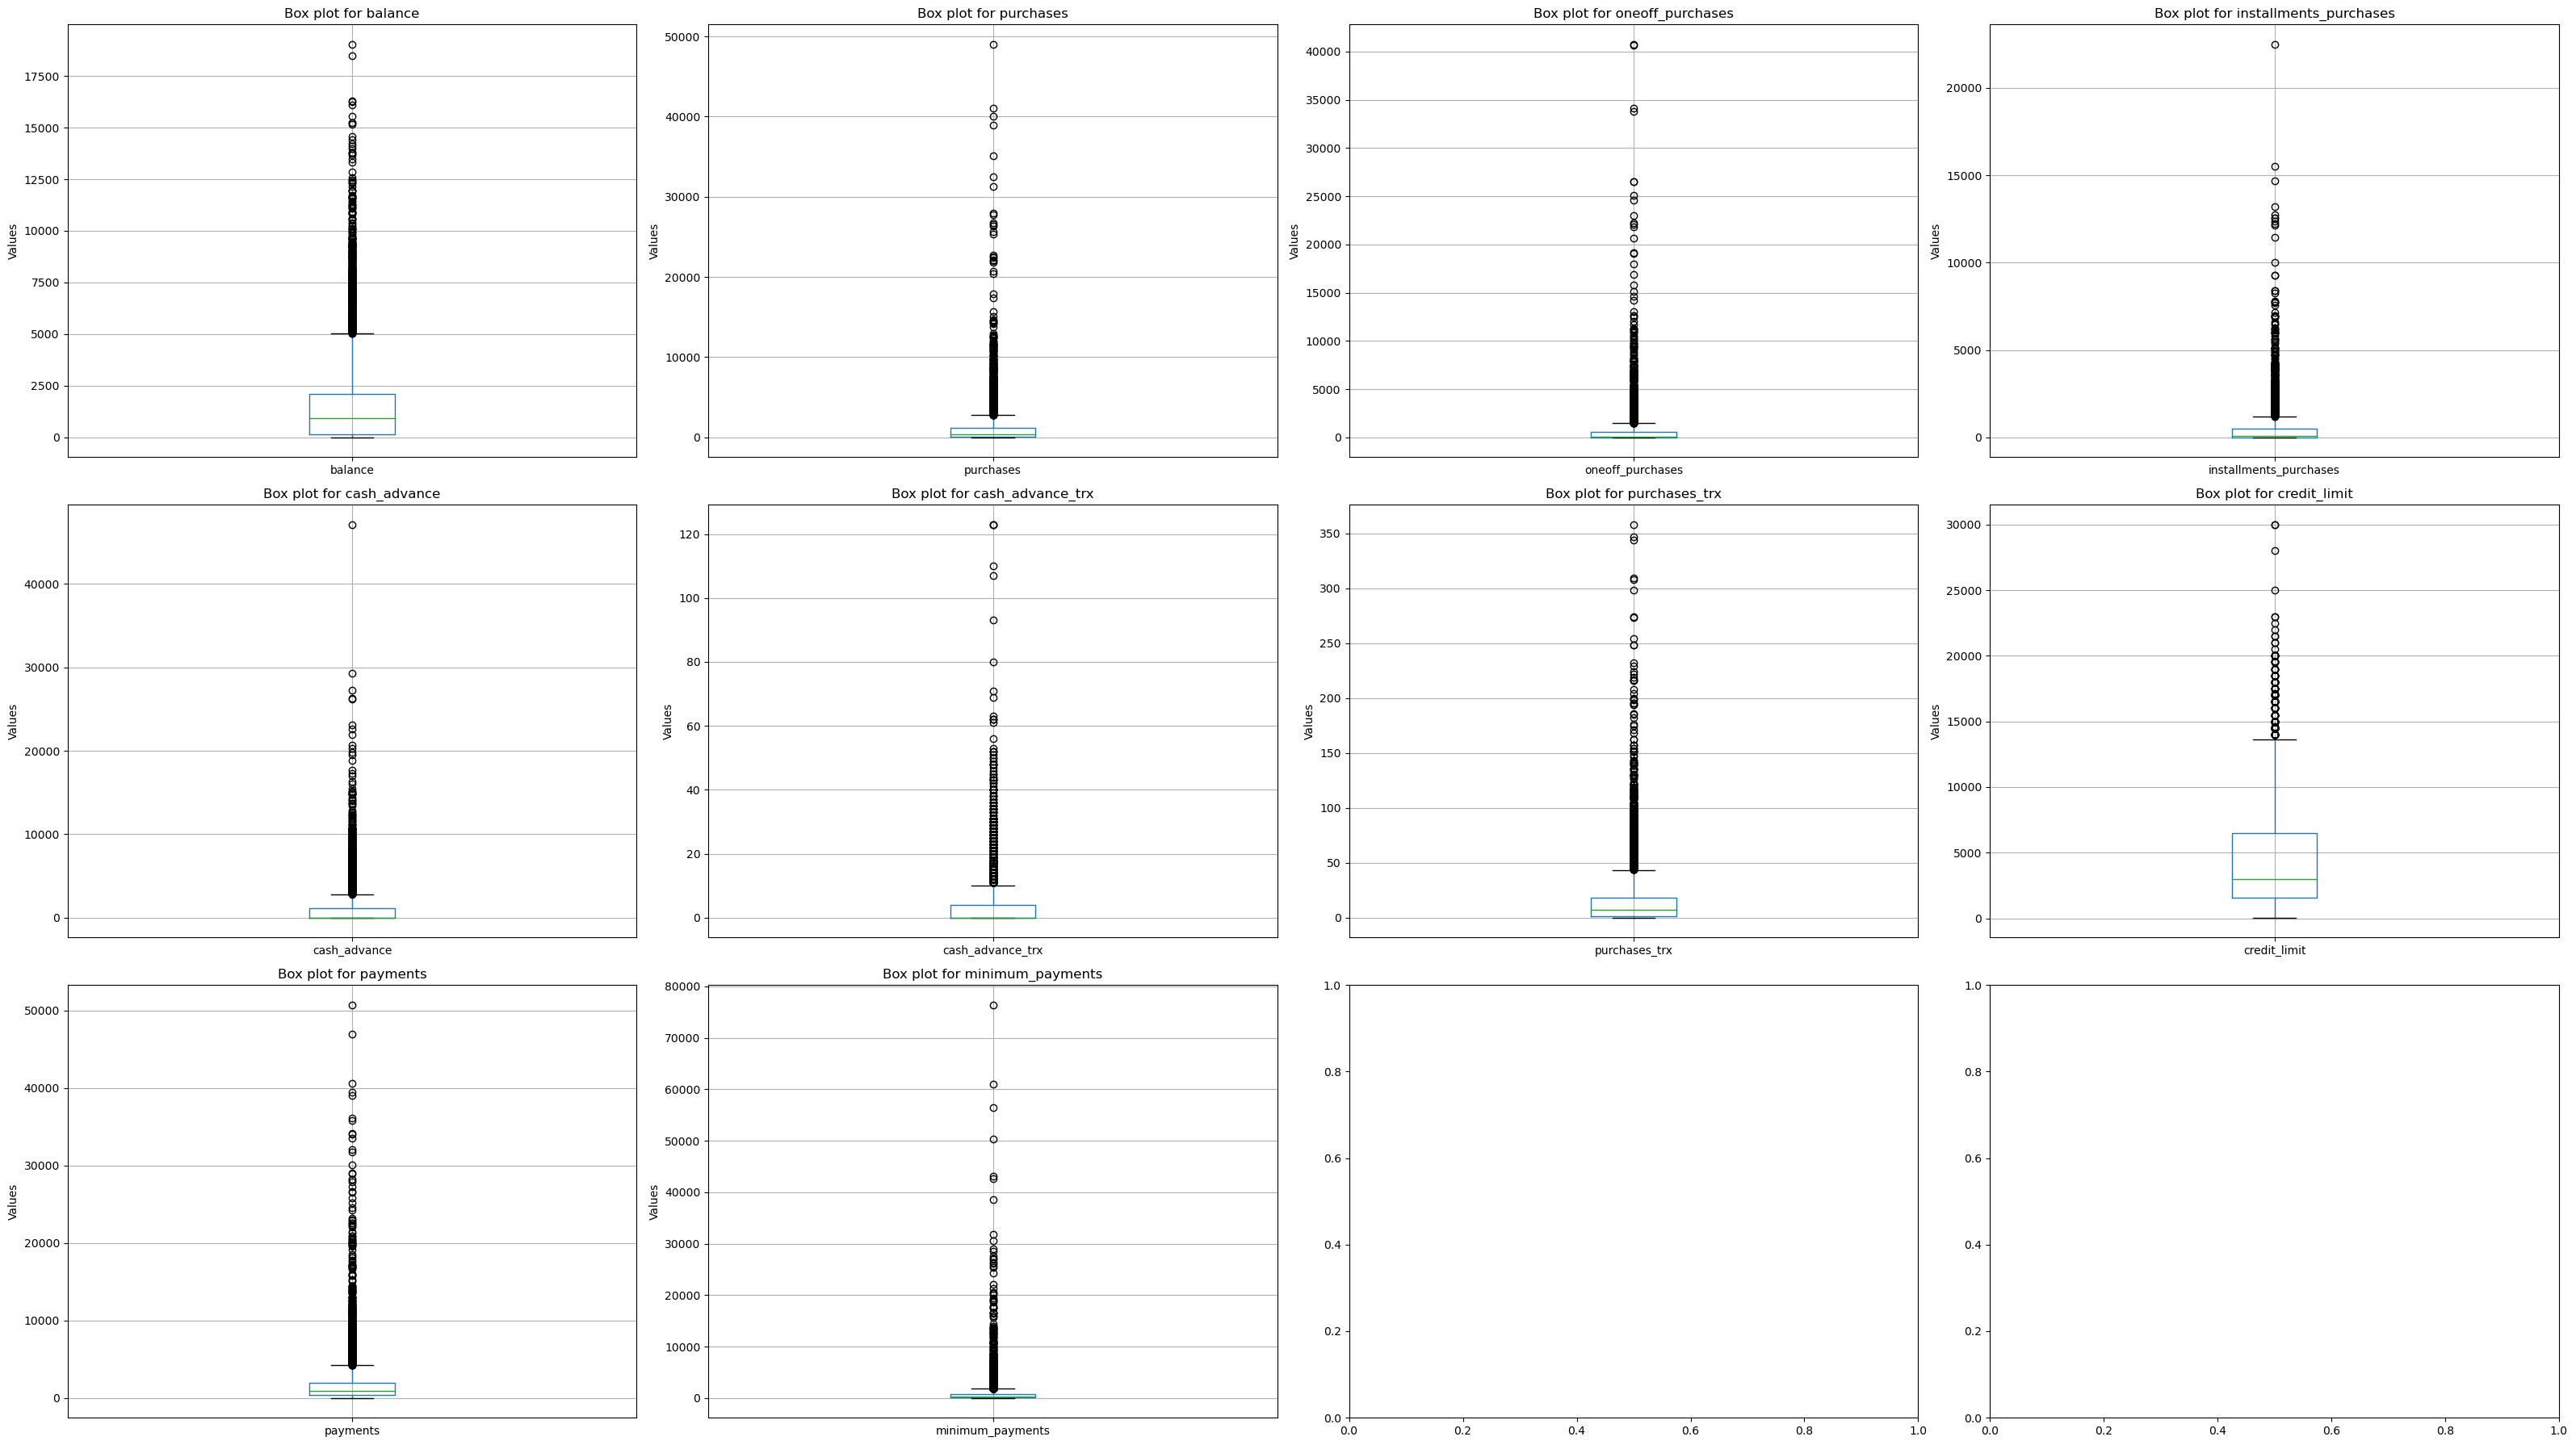

In [116]:
num_rows = 3
num_cols = len(numerical_columns) // num_rows + (len(numerical_columns) % num_rows > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
axes = axes.ravel()  # Flatten the axes array

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    df.boxplot(column=col, ax=ax)
    ax.set_title(f'Box plot for {col}')
    ax.set_ylabel('Values')

plt.tight_layout()
plt.show()

## Bivariate

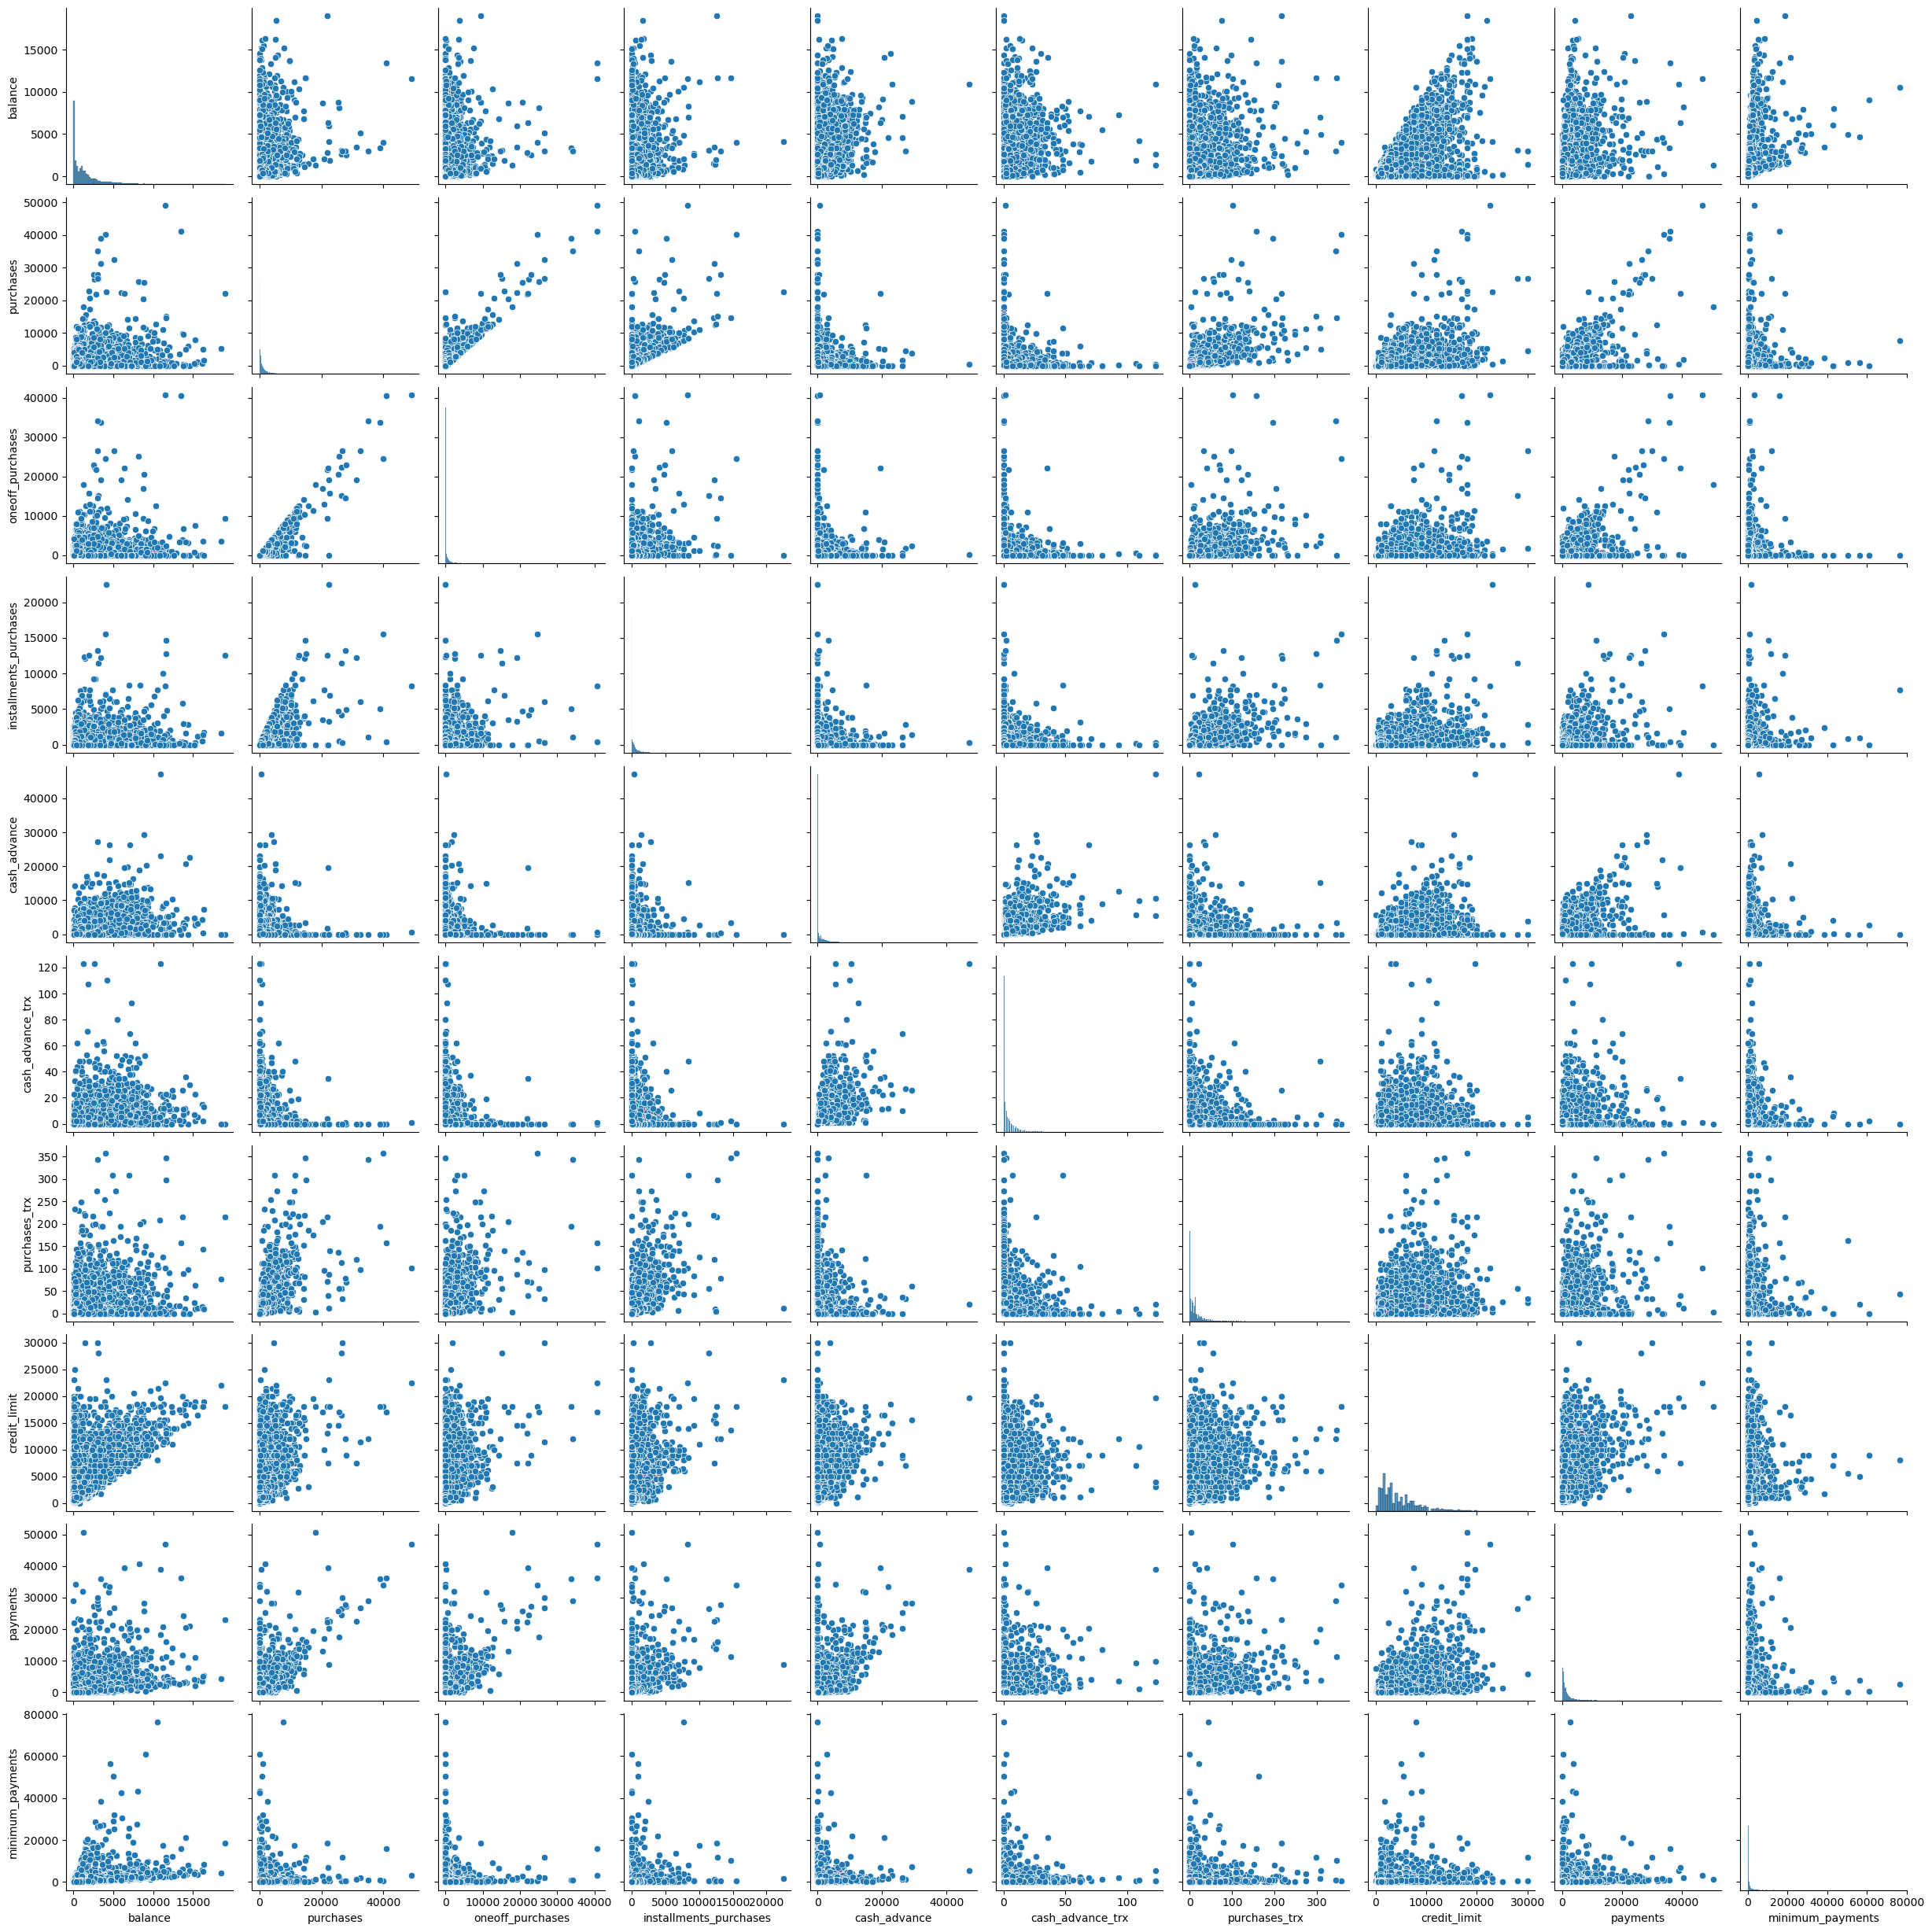

In [117]:
sns.pairplot(df[numerical_columns])

## Multivariate

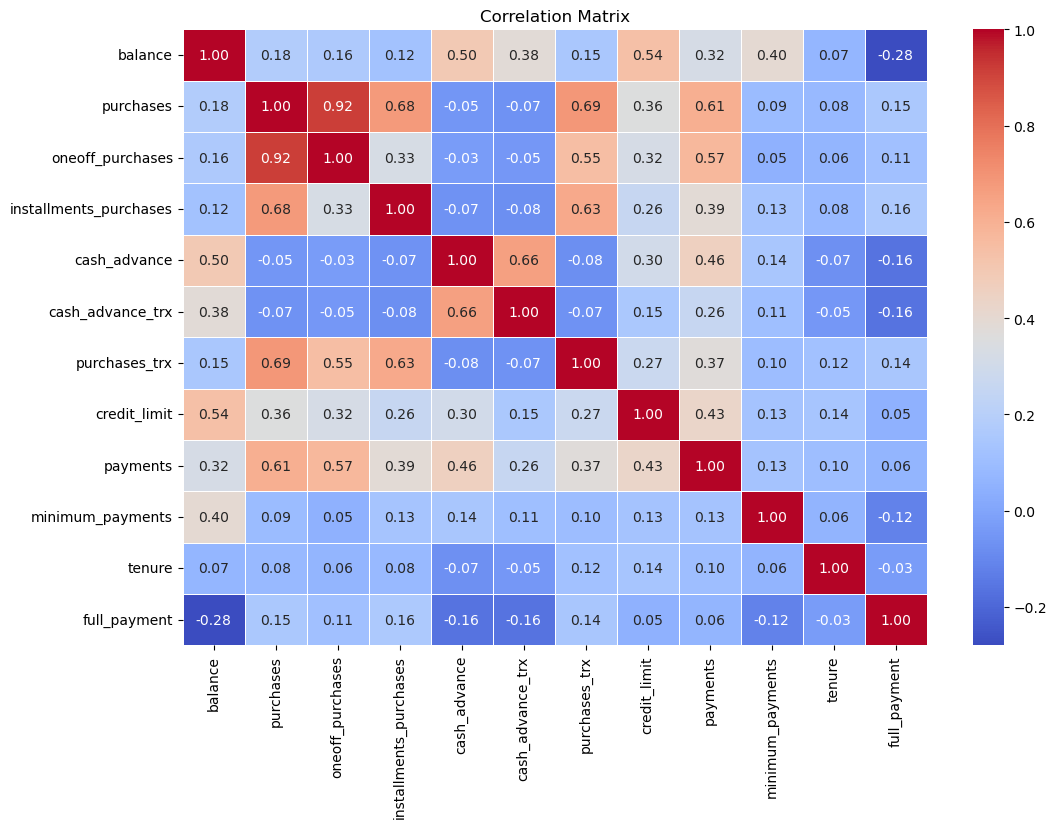

In [118]:
# Multivariate Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Kmeans Clustering Model

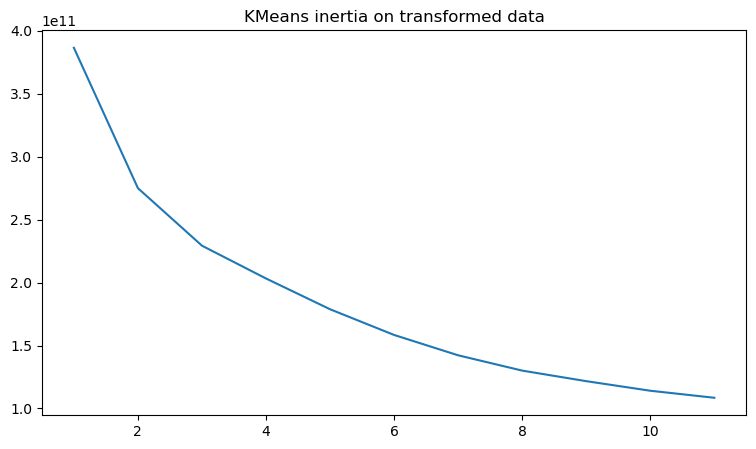

In [119]:
#Determine the number of clusters 
inertia_t = []
for i in range(1, 12):
    km = KMeans(n_clusters=i).fit(df)
    inertia_t.append(km.inertia_)

#Plot to check the suggested number of clusters
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
sns.lineplot(x=range(1,12), y=inertia_t)
plt.title('KMeans inertia on transformed data')
plt.show()

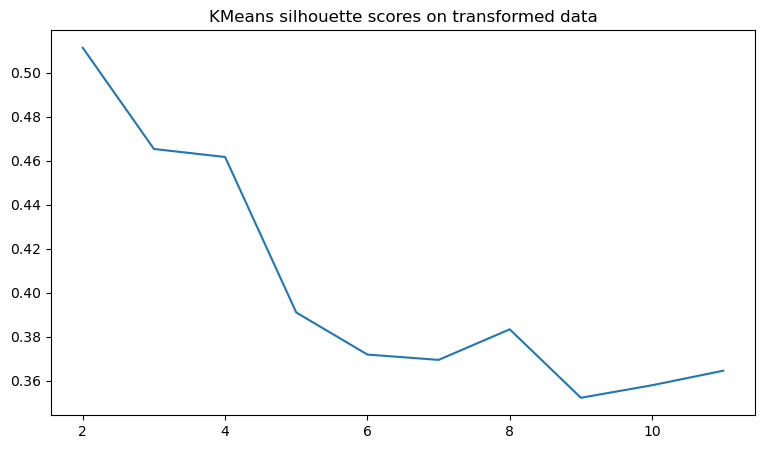

In [120]:
silhouette_scores = []

for i in range(2, 12):  # Considering clusters from 2 to 11
    km = KMeans(n_clusters=i)
    km.fit(df)
    silhouette_scores.append(silhouette_score(df, km.labels_))

#Plot to check the suggested number of clusters
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
sns.lineplot(x=range(2,12), y=silhouette_scores)
plt.title('KMeans silhouette scores on transformed data')
plt.show()

In [121]:
# Chose number of cluster = 4

In [122]:
#Build the model
kmeans4=KMeans(n_clusters=4,n_init=10,max_iter=500)
kmeans4.fit(df)

KMeans(max_iter=500, n_clusters=4, n_init=10)

In [123]:
#Add the clusters into the initial dataframe (centers)
df['clusters']=kmeans4.labels_ 

# take a look at the cluster center
kmeans4.cluster_centers_

array([[8.39094818e+02, 5.38635979e+02, 2.65559169e+02, 2.73385520e+02,
        4.97873392e+02, 2.34490996e+00, 9.96674017e+00, 2.28433241e+03,
        9.58764425e+02, 6.04192209e+02, 1.14141860e+01, 1.43513414e-01],
       [2.08246669e+03, 1.40797185e+03, 8.75320381e+02, 5.33050753e+02,
        1.09121887e+03, 3.45955591e+00, 2.01153846e+01, 7.53784140e+03,
        2.02917328e+03, 7.72027756e+02, 1.17359239e+01, 1.70896114e-01],
       [5.40533333e+03, 2.72763750e+04, 2.18770833e+04, 5.39912500e+03,
        1.55037500e+03, 2.50000000e+00, 1.27958333e+02, 1.60833333e+04,
        2.79255833e+04, 3.26666667e+03, 1.19166667e+01, 5.00000000e-01],
       [5.98784414e+03, 2.65270062e+03, 1.61459877e+03, 1.03824074e+03,
        4.76389198e+03, 1.09151235e+01, 3.36203704e+01, 1.11496991e+04,
        6.79838580e+03, 3.31890123e+03, 1.17453704e+01, 8.02469136e-02]])

In [124]:
import plotly.express as px

# Assuming df is your DataFrame with the specified columns

fig = px.scatter_3d(df, x='balance', y='purchases', z='payments', color='clusters',
                    symbol='clusters', opacity=0.7, size_max=10,
                    title='3D Scatter Plot of Clusters', color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()


In [128]:
fig = px.scatter(df, x='payments', y='balance', color='clusters',
                 symbol='clusters', opacity=0.7, size_max=10,
                 title='2D Scatter Plot of Clusters', color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()